# Common Libraris


In [26]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import re
import matplotlib.pyplot as plt
import warnings
import time
from wordcloud import WordCloud
warnings.filterwarnings("ignore")

# Fuctions

In [3]:
# ref:https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf
# ref:https://github.com/wjbmattingly/topic_modeling_textbook/blob/main/03_03_lda_model_demo_bigrams_trigrams.ipynb
# ref:http://topic-modeling.pythonhumanities.com/01_02_topics_and_clusters.html
def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=20)
    bigram = gensim.models.phrases.Phraser(bigram)
    return([bigram[doc] for doc in texts])
def make_trigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=20)
    bigram = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=20)
    trigram = gensim.models.phrases.Phraser(trigram)
    return ([trigram[bigram[doc]] for doc in texts])

In [24]:
# ref: https://datascience.oneoffcoder.com/topic-modeling-gensim.html
# ref: https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/
nlp = spacy.load("en_core_web_sm")

def preprocess(doc):
    my_token = []
    for text in nlp.pipe(doc, disable=["tagger", "parser", "ner","textcat"]):
        tokens = [token.lemma_.lower() for token in text if 
                  token.is_alpha and
                  not token.is_stop and 
                  not token.is_punct and
                  len(token) >= 3]
        my_token.append(tokens)
    res = [elements for elements in my_token if elements != []]
    return res

In [25]:
def dictionary(doc):
    my_dict = gensim.corpora.Dictionary(doc)
    # removed the stop words in lemmatization
    bad_ids = [i for t, i in my_dict.token2id.items() if nlp.vocab[t].is_stop]
    my_dict.filter_tokens(bad_ids=bad_ids)
    my_dict.filter_extremes(no_below=20, no_above=0.5)
    return my_dict


# convert list of tokens to bag of word representation
def corpus(id2word,lemmatized_doc):
    my_corpus = [id2word.doc2bow(doc) for doc in lemmatized_doc]
    my_corpus = [elements for elements in my_corpus if elements != []]
    return my_corpus


# Comments data preparation

In [15]:
# preparing comments data
GB_videos = pd.read_csv("GBvideos.csv",on_bad_lines='skip')
GB_comments = pd.read_csv("GBcomments.csv",on_bad_lines='skip')

GB_videos.info()
GB_videos = GB_videos.dropna()
med_GB_videos=GB_videos.sample(50,random_state=10,)
med_GB_comments = GB_comments[GB_comments['video_id'].isin(med_GB_videos['video_id'])]
med_GB_comments.info()
set(med_GB_comments['video_id'].unique()).issubset(set(med_GB_videos['video_id'].unique()))
print(med_GB_videos['category_id'].unique())
len(med_GB_videos['category_id'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7993 entries, 0 to 7992
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        7993 non-null   object 
 1   title           7993 non-null   object 
 2   channel_title   7993 non-null   object 
 3   category_id     7993 non-null   int64  
 4   tags            7993 non-null   object 
 5   views           7993 non-null   int64  
 6   likes           7993 non-null   int64  
 7   dislikes        7993 non-null   int64  
 8   comment_total   7993 non-null   int64  
 9   thumbnail_link  7993 non-null   object 
 10  date            7993 non-null   float64
dtypes: float64(1), int64(5), object(5)
memory usage: 687.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 175212 entries, 400 to 717931
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   video_id      175212 non-null  object
 1 

14

In [16]:
med_GB_comments = med_GB_comments.dropna()

In [17]:
med_GB_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175207 entries, 400 to 717931
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   video_id      175207 non-null  object
 1   comment_text  175207 non-null  object
 2   likes         175207 non-null  int64 
 3   replies       175207 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.7+ MB


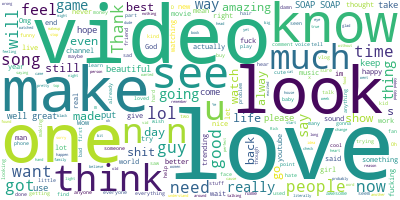

In [18]:
med_string = ','.join(list(med_GB_comments['comment_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(med_string)

# Visualize the word cloud
wordcloud.to_image()

# Preprocssing comments data

In [19]:
start_time = time.time()
dataset = preprocess(med_GB_comments['comment_text'].astype(str))
print("--- %s seconds ---" % (time.time() - start_time))

--- 211.5321991443634 seconds ---


In [20]:
dataset = make_trigrams(dataset)

In [21]:
med_dict = dictionary(dataset)
med_corpus = corpus(med_dict,dataset)

In [22]:
print('Number of unique tokens: %d' % len(med_dict))
print('Number of documents: %d' % len(med_corpus))

Number of unique tokens: 0
Number of documents: 0


In [23]:
med_word_list = ','.join(str(elem) for elem in dataset)
# Join the different processed titles together.

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(med_word_list)

# Visualize the word cloud
wordcloud.to_image()

ValueError: We need at least 1 word to plot a word cloud, got 0.

# Word2Vec-LSA

In [27]:
from gensim import models
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize

In [ ]:
import random
random.seed(10)
start_time = time.time()
# Train the Word2Vec model
w2v_model = models.word2vec.Word2Vec(dataset, window=5, min_count=5,seed=10)

# Get the word vectors from the Word2Vec model
word_vectors = w2v_model.wv.vectors

normalized_word_vectors = normalize(word_vectors)
coherence_scores = []

num_clusters = range(5,26,5)
for cluster in num_clusters:
    kmeans = MiniBatchKMeans(n_clusters=cluster, 
                             init='k-means++',
                             n_init=10, 
                             batch_size=100,
                             random_state=10)

    cluster_labels = kmeans.fit(normalized_word_vectors)
    cluster_labels = kmeans.predict(normalized_word_vectors)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
num_clusters = 5 #change the clusters at each round and save the topics


kmeans = MiniBatchKMeans(n_clusters=num_clusters, 
                             init='k-means++',
                             n_init=10, 
                             batch_size=100,
                             random_state=10)

cluster_labels = kmeans.fit(normalized_word_vectors)
cluster_labels = kmeans.predict(normalized_word_vectors)
cluster_centers = kmeans.cluster_centers_
transformed_vectors = kmeans.transform(normalized_word_vectors)

# Find the indices of the words closest to each cluster center and print them
for i in range(num_clusters):
    closest_indices = np.argsort(transformed_vectors[:, i])[:10]
    closest_words = [w2v_model.wv.index_to_key[idx] for idx in closest_indices]
    print(f"Retrieved top words for cluster {i}: {closest_words}")

# N-cut-weighted NMF

In [35]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.coherencemodel import CoherenceModel
start_time = time.time()
#ref:https://stackoverflow.com/questions/45547568/how-can-i-prevent-tfidfvectorizer-to-get-numbers-as-vocabulary
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1, 3),token_pattern =r'\b[A-Za-z]{3,}\b')
tfidf = vectorizer.fit_transform(med_GB_comments['comment_text'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.317051887512207 seconds ---


In [30]:
start_time = time.time()
# calculate cosine similarity matrix
similarity = cosine_similarity(tfidf)
# compute N-cut weights using the cosine similarity matrix
ncut_weights = np.exp(-(1 - similarity))

topics = range(5,21,5)

uci_coherence_scores = []
umass_coherence_scores = []
for num_topics in topics:
    nmf_model = NMF(n_components=num_topics,
                    init='nndsvd',
                    random_state=10)

    weights = nmf_model.fit_transform(tfidf)

    # normalize the topic weights
    normalized_weights = weights / weights.sum(axis=1, keepdims=True)

    # multiply the topic weights with the N-cut weights to get the final topic weights
    ncut_topic_weights = np.dot(normalized_weights.T, ncut_weights)

    terms = np.argsort(nmf_model.components_)[:, ::-1][:, :10]
    terms_words = [[vectorizer.get_feature_names_out()[i] for i in term] for term in terms]
    coherence_model = CoherenceModel(topics=topic_terms_words,
                                      corpus=med_corpus,
                                      dictionary=med_dict,
                                      coherence='c_uci',
                                      texts=dataset)
    coherence = coherence_model.get_coherence()
    uci_coherence_scores.append(coherence)

    coherence_model = CoherenceModel(topics=topic_terms_words,
                                 corpus=med_corpus,
                                 dictionary=med_dict,
                                 coherence='u_mass')
    coherence = coherence_model.get_coherence()
    umass_coherence_scores.append(coherence)
print("--- %s seconds ---" % (time.time() - start_time))

--- 205.7901692390442 seconds ---


In [ ]:
num_topics = 5 # change to 10,15,20 to get the topics
uci_coherence_scores = []
umass_coherence_scores = []
nmf_model = NMF(n_components=num_topics,
                init='nndsvd',
                random_state=10)

weights = nmf_model.fit_transform(tfidf)

# normalize the topic weights
normalized_weights = weights / weights.sum(axis=1, keepdims=True)

# multiply the topic weights with the N-cut weights to get the final topic weights
ncut_topic_weights = np.dot(normalized_weights.T, ncut_weights)

terms = np.argsort(nmf_model.components_)[:, ::-1][:, :10]
terms_words = [[vectorizer.get_feature_names_out()[i] for i in term] for term in terms]
coherence_model = CoherenceModel(topics=topic_terms_words,
                                  corpus=med_corpus,
                                  dictionary=med_dict,
                                  coherence='c_uci',
                                  texts=dataset)
coherence = coherence_model.get_coherence()
uci_coherence_scores.append(coherence)

coherence_model = CoherenceModel(topics=topic_terms_words,
                             corpus=med_corpus,
                             dictionary=med_dict,
                             coherence='u_mass')
coherence = coherence_model.get_coherence()
umass_coherence_scores.append(coherence)
print(f"Retrieved top words for cluster {num_topics}: {terms_words}")